## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Дегтярёв Роман Олегович

In [308]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm


%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [82]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [289]:
mnist = fetch_mldata('MNIST original')
images = mnist['data']
images = images.reshape(images.shape[0], 1, 28, 28)
labels = mnist['target'].astype(int)
np.random.seed(777)
images_train, images_test, labels_train, labels_test = train_test_split(images, labels)
images_train = torch.from_numpy(images_train).type(torch.FloatTensor)
images_test = torch.from_numpy(images_test).type(torch.FloatTensor)
labels_train = torch.from_numpy(labels_train)
labels_test = torch.from_numpy(labels_test)

In [256]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

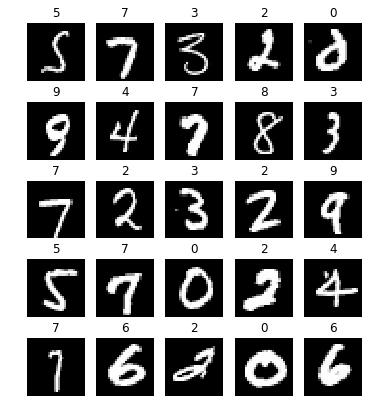

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [294]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0.0, std=0.1)

def forward_hook(self, input_, output):
        std = input_[0].std().data[0]
        print 'forward', std

def backward_hook(self, grad_input, grad_output):
        if grad_input[1] is not None:
            std = grad_input[1].std().data[0]
            print 'backward', std

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [295]:
def fully_connected(init_func, arc):
    layers = []
    for i in range(len(arc)-1):
        layer = nn.Linear(arc[i], arc[i+1])
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)
        init_func(layer)
        layers.append(layer)
        layers.append(nn.Tanh())
    layer = nn.Linear(500, 10)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    layers.append(layer)
    layers.append(nn.Tanh())
    return nn.Sequential(*layers)

In [296]:
model = fully_connected(init_layer, [28*28,500]*5)

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [297]:
##### YOUR CODE HERE #####


#пример:
n_objects = 32
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = model(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 77.3860931396
forward 0.99815672636
forward 0.815977811813
forward 0.819363713264
forward 0.777672469616
forward 0.813273251057
forward 0.776258289814
forward 0.815135002136
forward 0.776411473751
forward 0.811492502689
backward 0.00168040301651
backward 0.00185743556358
backward 0.00283487187698
backward 0.00302508566529
backward 0.00455341953784
backward 0.00475850095972
backward 0.00695034954697
backward 0.00757425185293
backward 0.0101488670334


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [298]:
##### YOUR CODE HERE #####
def init_layer_X(layer):
    weight = layer.state_dict()['weight']
    n_out,n_in = weight.size()
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(-np.sqrt(6)/(np.sqrt(n_in  + n_out)),np.sqrt(6)/(np.sqrt(n_in  + n_out)))

In [299]:
model = fully_connected(init_layer_X, [28*28,500]*5)

In [300]:
n_objects = 32
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = model(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 77.3860931396
forward 0.995325446129
forward 0.586957335472
forward 0.495509833097
forward 0.380415767431
forward 0.365665614605
forward 0.292789876461
forward 0.297633528709
forward 0.249267160892
forward 0.258315742016
backward 0.00171614077408
backward 0.00141501065809
backward 0.00145198323298
backward 0.00115435617045
backward 0.00117302173749
backward 0.000904838962015
backward 0.000865840760525
backward 0.00059834937565
backward 0.000476483721286


In [301]:
def init_layer_H(layer):
    weight = layer.state_dict()['weight']
    n_out,n_in = weight.size()
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0.,std=np.sqrt(2.)/n_out)

In [302]:
model = fully_connected(init_layer_H, [28*28,500]*5)

In [303]:
n_objects = 32
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = model(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 77.3860931396
forward 0.934852778912
forward 0.0374297946692
forward 0.0029778550379
forward 0.000120245531434
forward 9.45422470977e-06
forward 3.81237697411e-07
forward 2.9735314655e-08
forward 1.19591447856e-09
forward 9.40992422871e-11
backward 0.00444325152785
backward 0.000282794469967
backward 1.43332617881e-05
backward 9.070803344e-07
backward 4.58142928039e-08
backward 2.88482482347e-09
backward 1.43376852058e-10
backward 8.99974712809e-12
backward 4.55412129449e-13


<i> 1.4 Сделайте выводы по первой части </i>

In [304]:
#Вывод: 
#В отличие от обычной инициализации N(0, 0.1) инициализация Xavier дает непостоянные веса на всех слоях. 
#Однако использование He приводит к быстрой сходимости

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [317]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры
# не забывайте, что в pyTorch нету broadcasting (делайте .expand)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.weight = torch.nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=0, std=0.01), requires_grad=True)
        self.bias = torch.nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p
        self.n_in = input_dim
        self.n_out = output_dim

    def forward(self, x):
        self.mask = Variable(torch.Tensor(self.n_in,self.n_out).bernoulli_(self.p),requires_grad=False)
        batch_size = x.mm(self.weight*self.mask).size()[0]
        output = x.mm(self.weight*self.mask) + self.bias.repeat(batch_size,1) ##### YOUR CODE HERE #####
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [325]:
network_one = nn.Sequential(
                            nn.Linear(784,200),
                            nn.ReLU(),
                            nn.Dropout(),
                            nn.Linear(200,10),
                            nn.ReLU(),
                            nn.Dropout(),
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network_one.parameters(), lr=0.001)

In [326]:
batch_size = 50
n_epochs = 10

losses = [] 
for j in xrange(n_epochs):
    for i in tqdm(xrange(0,20000, batch_size)):
        X = Variable(images_train[i:i+batch_size], requires_grad=False).view(batch_size, -1)
        y = Variable(labels_train[i:i+batch_size], requires_grad=False)
        activations = network_one(X)
         
        loss = loss_fn(activations, y)
        losses.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 400/400 [00:04<00:00, 80.04it/s]


In [327]:
network_two = nn.Sequential(
                            DropConnect(784,200),
                            nn.ReLU(),
                            DropConnect(200,10),
                            nn.ReLU(),
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network_two.parameters(), lr=0.001)

In [328]:
batch_size = 50
n_epochs = 10

losses_2 = [] 
for j in xrange(n_epochs):
    for i in tqdm(xrange(0,20000,batch_size)):
        X = Variable(images_train[i:i+batch_size], requires_grad=False).view(batch_size, -1)
        y = Variable(labels_train[i:i+batch_size], requires_grad=False)
        activations = network_two(X)
        loss = loss_fn(activations, y)
        losses_2.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 400/400 [00:06<00:00, 64.00it/s]


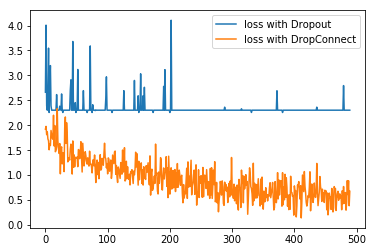

In [333]:
plt.plot(losses[10:500],label='loss with Dropout')
plt.plot(losses_2[10:500],label='loss with DropConnect')
plt.legend()

<i> 2.3 Сделайте выводы по третьей части </i>

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [342]:
# полезные функции: .std(dim), .mean(dim)
# не забывайте, что в pyTorch нету broadcasting (делайте .expand)

class LayerNormalization(nn.Module):
    def __init__(self):
        super(LayerNormalization, self).__init__()
        self.gamma = torch.nn.Parameter(torch.Tensor([1.0]))
        self.beta = torch.nn.Parameter(torch.Tensor([0.0]))
        
    def forward(self, x):
        batch_size,n_activations = x.size()
        output = self.gamma.repeat(batch_size,n_activations)*(x - x.mean(1).repeat(1,n_activations))/x.std(1).repeat(1,n_activations) \
        + self.beta.repeat(batch_size,n_activations)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [343]:
network_three = nn.Sequential(
                            nn.Linear(784,200),
                            nn.BatchNorm1d(200),
                            nn.Sigmoid(),
                            nn.Linear(200,10),
                            nn.BatchNorm1d(10),
                          
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network_three.parameters(), lr=0.001)

In [338]:
batch_size = 50
n_epochs = 10

losses = [] 
for j in xrange(n_epochs):
    for i in tqdm(xrange(0,20000,batch_size)):
        X = Variable(images_train[i:i+batch_size], requires_grad=False).view(batch_size, -1)
        y = Variable(labels_train[i:i+batch_size], requires_grad=False)
        activations = network_three(X)
         
        loss = loss_fn(activations, y)
        losses.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 400/400 [00:02<00:00, 136.09it/s]


In [344]:
network_four = nn.Sequential(
                            nn.Linear(784,200),
                            LayerNormalization(),
                            nn.Sigmoid(),
                            nn.Linear(200,10),
                            LayerNormalization(),
                           
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network_four.parameters(), lr=0.001)

In [345]:
batch_size = 50
n_epochs = 10

losses_2 = [] 
for j in xrange(n_epochs):
    for i in tqdm(xrange(0,20000,batch_size)):
        X = Variable(images_train[i:i+batch_size], requires_grad=False).view(batch_size, -1)
        y = Variable(labels_train[i:i+batch_size], requires_grad=False)
        activations = network_four(X)
         
        loss = loss_fn(activations, y)
        losses_2.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/400 [00:00<?, ?it/s]/Users/romandegtyarev/anaconda/lib/python2.7/site-packages/torch/autograd/_functions/basic_ops.py:34: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return a.sub(b)
/Users/romandegtyarev/anaconda/lib/python2.7/site-packages/torch/autograd/_functions/basic_ops.py:63: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return a.div(b)
/Users/romandegtyarev/anaconda/lib/python2.7/site-packages/torch/autograd/_functions/basic_ops.py:48: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return a.mul(b)
100%|██████████| 400/400 [00:12<00:00, 32.41it/s]


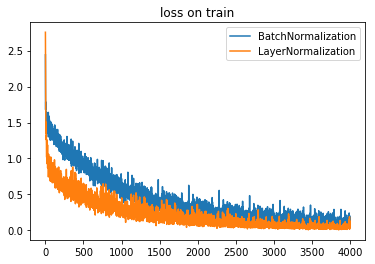

In [346]:
plt.plot(losses,label='BatchNormalization')
plt.plot(losses_2,label='LayerNormalization')
plt.title('loss on train')
plt.legend()

<i> 3.3 Сделайте выводы по третьей части </i>

In [347]:
#Cходимость примерно одинаковая, в конце практически незаметно разницы

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: